In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn

import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

# Try to get torchinfo, install it if it doesn't work
# Can use for printing Model summaries
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
# Used for converting "notebook" code to ".py" so that we can import libraries/functions ...
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/mnt/hd1/ani/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Data transforms
# Lets keep it simple here!
Img_size = 224
img_transforms = transforms.Compose([transforms.Resize((Img_size, Img_size)), 
                                     transforms.ToTensor()])

In [4]:
# Dataset
dataset = ImageFolder('/Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Liver_biopsy/Small dataset_balanced classes_Nclass_500/', 
                      transform=img_transforms)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Liver_biopsy/Small dataset_balanced classes_Nclass_500/'

In [95]:
# Split dataset into "training" and "validation"
def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# print(len(dataset))
datasets_spl = train_val_dataset(dataset)
# print(len(datasets['train']))
# print(len(datasets['val']))

# The original dataset is available in the Subset class
# print(datasets['train'].dataset)

batch_size = 32
dataloaders = {x:DataLoader(datasets_spl[x], batch_size, shuffle=True, num_workers=2) for x in ['train','val']}
images, labels = next(iter(dataloaders['train']))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


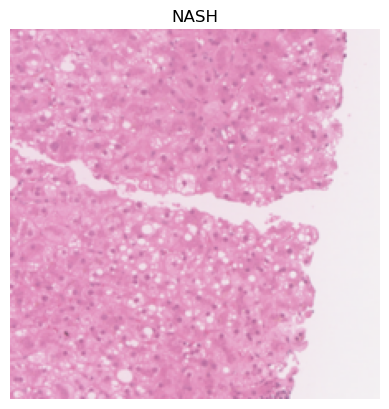

In [96]:
# Visualize a few class examples
class_names = {1: 'NASH', 0: 'ACR'}
index = np.random.randint(0, batch_size)   # select random image for visualization
plt.imshow(images[index].permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[int(np.array(labels[index]))])
plt.axis(False);

# Constructing the Vision Transformer (ViT)

In [97]:
### Calculating patch embedding input and output shapes by hand
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P, this is recommended from ViT paper

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [98]:
### Embedding layer output
# Input shape (this is the size of a single image) - (H, W, C)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape - (N_patches, (P^2*C))
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


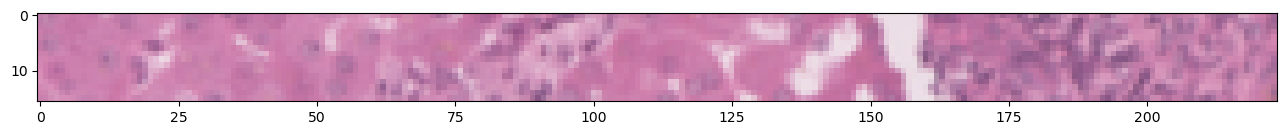

In [103]:
### Turning a single image into patches
ind = np.random.randint(0, batch_size)   # select random image for visualization
image = images[ind]

# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


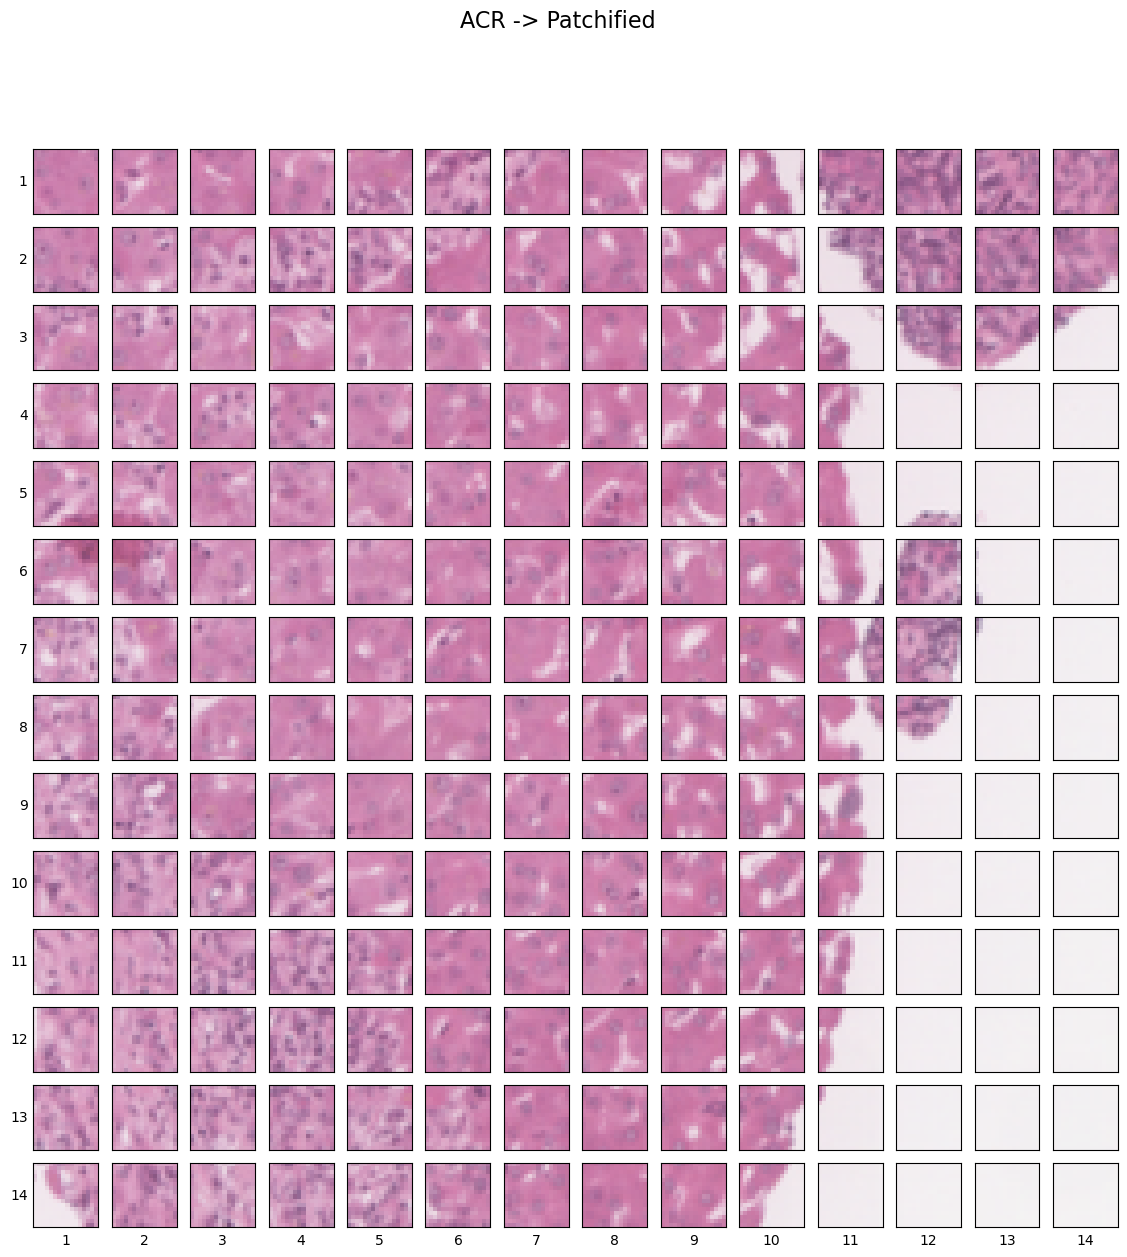

In [105]:
### Creating patches for whole image
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height; range -->(start, stop, step)
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[int(np.array(labels[ind]))]} -> Patchified", fontsize=16)
plt.show()

# Using convolutions to achieve image patches

In [110]:
# torch.nn.Conv2d() for turning our image into patches of CNN feature maps
# torch.nn.Flatten() for flattening the spatial dimensions of the feature map

# set the kernel_size and stride equal to patch_size
# This means each convolutional kernel will be of size (patch_size x patch_size) or if patch_size=16, (16 x 16) 
# (the equivalent of one whole patch).

# And each step or stride of the convolutional kernel will be patch_size pixels long or 16 pixels long 
# (equivalent of stepping to the next patch).

# We'll set in_channels=3 for the number of color channels in our image and we'll set out_channels=768 (P^2 * C), the same 
# as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a 
# learnable vector of size 768)

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

# Pass the image through the convolutional layer 
ind = np.random.randint(0, batch_size)   # select random image for visualization
image = images[ind]   # (num_channels, H, W)

image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [260, 706, 117, 723, 71]


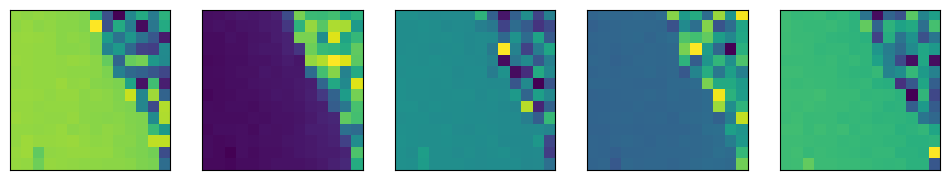

In [115]:
# Plot random 5 convolutional feature maps
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [120]:
# Notice how the feature maps all kind of represent the original image, after visualizing a few more you can start to see the different major outlines and some major features.
# The important thing to note is that these features may change over time as the neural network learns.
# And because of these, these feature maps can be considered a learnable embedding of our image.
# Let's check one out in numerical form

# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

# The grad_fn output of the single_feature_map and the requires_grad=True attribute means PyTorch is tracking the 
# gradients of this feature map and it will be updated by gradient descent during training.

(tensor([[[0.2811, 0.2802, 0.2808, 0.2816, 0.2800, 0.2819, 0.2815, 0.2118,
           0.3057, 0.2718, 0.3318, 0.3168, 0.2830, 0.2625],
          [0.2813, 0.2817, 0.2829, 0.2818, 0.2824, 0.2820, 0.2807, 0.2964,
           0.2759, 0.2158, 0.3185, 0.3160, 0.2292, 0.3119],
          [0.2792, 0.2795, 0.2797, 0.2809, 0.2809, 0.2792, 0.2821, 0.2824,
           0.3461, 0.3731, 0.2810, 0.2452, 0.2595, 0.3204],
          [0.2811, 0.2800, 0.2802, 0.2814, 0.2829, 0.2828, 0.2818, 0.2812,
           0.2464, 0.2851, 0.3254, 0.3500, 0.3347, 0.3180],
          [0.2811, 0.2799, 0.2801, 0.2808, 0.2804, 0.2804, 0.2827, 0.2814,
           0.2588, 0.2915, 0.2452, 0.2848, 0.3957, 0.2503],
          [0.2807, 0.2799, 0.2821, 0.2808, 0.2807, 0.2817, 0.2818, 0.2806,
           0.2856, 0.3918, 0.3836, 0.3023, 0.2535, 0.2673],
          [0.2804, 0.2815, 0.2811, 0.2813, 0.2820, 0.2827, 0.2825, 0.2817,
           0.2812, 0.2840, 0.3390, 0.2911, 0.3665, 0.2071],
          [0.2820, 0.2809, 0.2800, 0.2801, 0.2810, 0.28

# Flattening patch embedding

In [121]:
# We've turned our image into patch embeddings but they're still in 2D format.

# How do we get them into the desired output shape of the patch embedding layer of the ViT model?

# Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -> 
# N * (P^2*C)

# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [122]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

# Putting it together

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


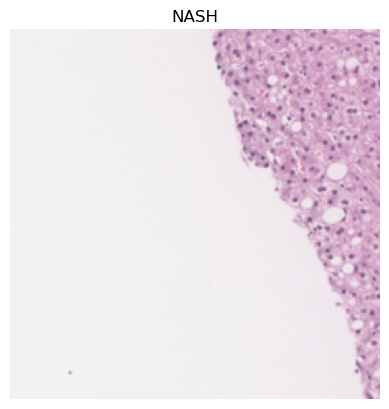

In [129]:
# [1] Take a single image
# [2] Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings)
# [3] Flatten the 2D feature map into a single sequence

# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[int(np.array(labels[index]))])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [124]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


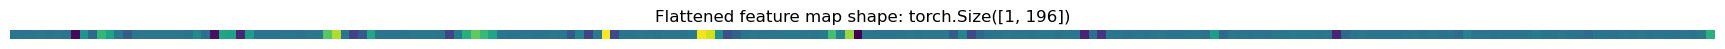

In [125]:
# We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a 
# couple of PyTorch layers.

# How about we visualize one of the flattened feature maps?

# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [126]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.2811, 0.2802, 0.2808, 0.2816, 0.2800, 0.2819, 0.2815, 0.2118, 0.3057,
          0.2718, 0.3318, 0.3168, 0.2830, 0.2625, 0.2813, 0.2817, 0.2829, 0.2818,
          0.2824, 0.2820, 0.2807, 0.2964, 0.2759, 0.2158, 0.3185, 0.3160, 0.2292,
          0.3119, 0.2792, 0.2795, 0.2797, 0.2809, 0.2809, 0.2792, 0.2821, 0.2824,
          0.3461, 0.3731, 0.2810, 0.2452, 0.2595, 0.3204, 0.2811, 0.2800, 0.2802,
          0.2814, 0.2829, 0.2828, 0.2818, 0.2812, 0.2464, 0.2851, 0.3254, 0.3500,
          0.3347, 0.3180, 0.2811, 0.2799, 0.2801, 0.2808, 0.2804, 0.2804, 0.2827,
          0.2814, 0.2588, 0.2915, 0.2452, 0.2848, 0.3957, 0.2503, 0.2807, 0.2799,
          0.2821, 0.2808, 0.2807, 0.2817, 0.2818, 0.2806, 0.2856, 0.3918, 0.3836,
          0.3023, 0.2535, 0.2673, 0.2804, 0.2815, 0.2811, 0.2813, 0.2820, 0.2827,
          0.2825, 0.2817, 0.2812, 0.2840, 0.3390, 0.2911, 0.3665, 0.2071, 0.2820,
          0.2809, 0.2800, 0.2801, 0.2810, 0.2820, 0.2806, 0.2828, 0.2815, 0.2820,
          0.2621

# Turning the ViT patch embedding layer into a PyTorch module

In [130]:
# 1. Create a "Patch embedding" class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [131]:
### Lets try it out on a single image
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [132]:
### Lets now get a summary of our PatchEmbedding layer

# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will give error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/Users/anirudhgangadhar/opt/miniconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/anirudhgangadhar/opt/miniconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

# Creating the class token embedding

In [133]:
# we need to "preprend a learnable embedding to the sequence of embedded patches

# Let's start by viewing our sequence of embedded patches tensor (created in section 4.5) and its shape

# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.1374,  0.4058, -0.4606,  ...,  0.0036, -0.5798,  0.2222],
         [ 0.1366,  0.4081, -0.4595,  ...,  0.0023, -0.5803,  0.2223],
         [ 0.1370,  0.4050, -0.4563,  ...,  0.0014, -0.5790,  0.2203],
         ...,
         [ 0.1407,  0.4028, -0.4501,  ...,  0.0032, -0.5752,  0.2217],
         [ 0.1363,  0.3936, -0.4407,  ...,  0.0024, -0.5754,  0.2178],
         [ 0.1794,  0.3904, -0.2445,  ..., -0.0320, -0.5244,  0.2235]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [139]:
# To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in 
# the shape of the embedding_dimension and then add it to the "number_of_patches" dimension

# Notice the concatenation (torch.cat()) happens on dim=1 (the number_of_patches dimension).

# Let's create a learnable embedding for the class token.

# To do so, we'll get the batch size and embedding dimension shape and then we'll create a torch.ones() tensor in the 
# shape [batch_size, 1, embedding_dimension].

# And we'll make the tensor learnable by passing it to nn.Parameter() with requires_grad=True

# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

# Note: Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, 
# you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the 
# power of controlled randomness, you generally start with a random number and improve it over time).

# See how the number_of_tokens dimension of class_token is 1 since we only want to prepend one class token value to the 
# start of the patch embedding sequence.

tensor([[[-0.1722,  0.8087, -0.3992,  0.1020,  2.7732, -1.8415, -1.1757,
          -0.2406, -0.4612,  1.3296]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [140]:
# Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image

# We can do so using torch.cat() and set dim=1 (so class_token's number_of_tokens dimension is preprended to 
# patch_embedded_image's number_of_patches dimension)

# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

# Reviewing what we've done to create the learnable class token, we start with a sequence of image patch embeddings 
# created by PatchEmbedding() on single image, we then created a learnable class token with one value for each of the 
# embedding dimensions and then prepended it to the original sequence of patch embeddings. Note:* Using torch.ones() to 
# create the learnable class token is mostly for demonstration purposes only, in practice, you'd like create it with
# torch.randn()

tensor([[[-0.1722,  0.8087, -0.3992,  ...,  1.3859,  1.3343,  1.0111],
         [ 0.1374,  0.4058, -0.4606,  ...,  0.0036, -0.5798,  0.2222],
         [ 0.1366,  0.4081, -0.4595,  ...,  0.0023, -0.5803,  0.2223],
         ...,
         [ 0.1407,  0.4028, -0.4501,  ...,  0.0032, -0.5752,  0.2217],
         [ 0.1363,  0.3936, -0.4407,  ...,  0.0024, -0.5754,  0.2178],
         [ 0.1794,  0.3904, -0.2445,  ..., -0.0320, -0.5244,  0.2235]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# Creating the position embedding

In [142]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.4932,  1.4095,  1.1032, -0.7781,  1.1235,  1.1379,  0.4234,
           1.5117,  0.3507, -1.1096],
         [-1.7293,  0.4106,  0.9937, -0.2310,  0.1089,  1.4759,  1.4941,
          -0.8529, -0.8774,  0.1658],
         [ 0.0911, -0.2315,  1.2940, -2.0802,  1.0594, -0.9247, -0.8575,
          -1.0732,  0.9569, -0.1566],
         [ 0.4746, -1.1738, -2.2377, -0.0288, -0.9263,  0.0241,  0.1659,
          -1.1110,  0.2279,  1.6541],
         [ 1.3391, -0.4546, -0.2207,  0.8755, -1.7562, -0.4452, -0.7754,
          -0.2947, -0.1763, -0.5253],
         [-0.1102, -0.1214, -0.0306,  1.4489, -1.5576, -0.0136, -0.9354,
           2.2765,  2.1605, -1.5742],
         [-0.7526, -0.5545,  1.8121, -0.1765, -1.6459,  0.9717, -0.0173,
           0.6597, -0.1846,  0.2786],
         [ 1.5821, -0.2895, -0.1616,  0.3175,  1.2932,  0.9989,  0.2401,
          -0.8575, -0.1411,  0.4378],
         [-0.5340,  1.6581, -1.7077,  0.6032,  1.0149, -1.4832,  0.0324,
          -0.3854,  0.0942, -1.0927],
 

In [143]:
# Position embeddings created!
# Let's add them to our sequence of patch embeddings with a prepended class token

# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 3.2105e-01,  2.2182e+00,  7.0397e-01,  ...,  6.8545e-01,
           3.0786e+00,  1.4242e+00],
         [-1.5920e+00,  8.1642e-01,  5.3310e-01,  ...,  1.0473e+00,
          -1.8916e+00, -6.4108e-01],
         [ 2.2766e-01,  1.7658e-01,  8.3449e-01,  ..., -1.1011e+00,
           7.4426e-01,  8.4330e-01],
         ...,
         [ 3.5513e-03, -1.0319e-01,  4.3982e-01,  ...,  6.7564e-01,
           1.0723e+00, -1.1703e+00],
         [-1.7995e+00, -1.0515e+00,  2.9832e-01,  ...,  1.9863e-04,
           1.7408e+00,  1.8781e+00],
         [-7.6427e-01,  8.9751e-01,  2.6972e-01,  ...,  5.7016e-01,
           3.9988e-01, -4.9299e-01]]], grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# Putting it all together: from image to embedding

In [150]:
torch.manual_seed(0)

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [151]:
### The LayerNorm (LN) layer
# Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

# You can find the formal definition of torch.nn.LayerNorm() in the PyTorch documentation.

# PyTorch's torch.nn.LayerNorm()'s main parameter is normalized_shape which we can set to be equal to the dimension size
# we'd like to noramlize over (in our case it'll be $D$ or 768 for ViT-Base).

# What does it do?

# Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

# I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples 
# into a similar distribution".

# Imagine trying to walk up (or down) a set of stairs all with differing heights and lengths.

# It'd take some adjustment on each step right?

# And what you learn for each step wouldn't necessary help with the next one since they all differ, increasing the 
# time it takes you to navigate the stairs.

# Normalization (including Layer Normalization) is the equivalent of making all the stairs the same height and length 
# except the stairs are your data samples.

# So just like you can walk up (or down) stairs with similar heights and lengths much easier than those with unequal 
# heights and widths, neural networks can optimize over data samples with similar distributions (similar mean and 
# standard-deviations) easier than those with varying distributions

# The Multi-Head Self Attention (MSA) layer

In [153]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [154]:
# Let's try it out by create an instance of our MultiheadSelfAttentionBlock and passing through the 
# patch_and_position_embedding variable we created

# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# Multi-layer Perceptron

In [155]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [156]:
# Let's try it out by create an instance of our MLPBlock and passing through the patched_image_through_msa_block 
# variable we created

# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# Creating the Transformer Encoder

In [157]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [158]:
# Let's get a torchinfo.summary() of passing an input of shape (1, 197, 768) -> (batch_size, num_patches, 
# embedding_dimension) to our Transformer Encoder block

# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/Users/anirudhgangadhar/opt/miniconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/anirudhgangadhar/opt/miniconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Creating a Transformer Encoder with PyTorch's Transformer layers

In [159]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [162]:
# To inspect it further, let's get a summary with torchinfo.summary().

# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]   [1, 197, 768]   7,087,872       True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Putting it all together to create ViT

In [163]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [164]:
# Let's create a quick demo to showcase what's happening with the class token embedding being expanded over the 
# batch dimensions

# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [166]:
# It's time to test out ViT() class
# Let's create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens

torch.manual_seed(0)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

# Our random image tensor made it all the way through our ViT architecture and it's outputting three logit values 
# (one for each class)
# And because our ViT class has plenty of parameters we could customize the img_size, patch_size or num_classes if we 
# wanted to

tensor([[-1.1963, -0.6038]], grad_fn=<AddmmBackward0>)

# Getting a visual summary of our ViT model

In [169]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
ViT (ViT)                                                    [32, 3, 224, 224] [32, 2]    152,064    True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224] [32, 196, 768] --         True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
│    └─Flatten (flatten)                                     [32, 768, 14, 14] [32, 768, 196] --         --
├─Dropout (embedding_dropout)                                [32, 197, 768] [32, 197, 768] --         --
├─Sequential (transformer_encoder)                           [32, 197, 768] [32, 197, 768] --         True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768] [32, 197, 768] --         True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768] [32, 197, 768] 2,363,904  True
│    │    └─MLPBlock (mlp_bloc

# Training our ViT model

In [173]:
# from going_modular.going_modular import engine

# # Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
# optimizer = torch.optim.Adam(params=vit.parameters(), 
#                              lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
#                              betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
#                              weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# # Setup the loss function for multi-class classification
# loss_fn = torch.nn.CrossEntropyLoss()

# # Set the seeds
# set_seeds()

# # Train the model and save the training results to a dictionary
# results = engine.train(model=vit,
#                        train_dataloader=dataloaders['train'],
#                        test_dataloader=dataloaders['val'],
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)

# Getting a pretrained ViT model and creating a feature extractor

In [175]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [178]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=12,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape  Output Shape Param #      Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 2]      768          Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)    False
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296      False
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --           --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --           False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] (7,087,872)  False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] (7,087,872)  False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] (7,087,872)  False
│   

In [179]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [180]:
# Dataset
dataset = ImageFolder('/Users/anirudhgangadhar/Desktop/UHN_Postdoc/Data and results/Liver_biopsy/Small dataset_balanced classes_Nclass_500/', 
                      transform=pretrained_vit_transforms)

In [183]:
# Split dataset into "training" and "validation"
def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# print(len(dataset))
datasets_spl = train_val_dataset(dataset)
# print(len(datasets['train']))
# print(len(datasets['val']))

# The original dataset is available in the Subset class
# print(datasets['train'].dataset)

batch_size = 32
dataloaders_pretrained = {x:DataLoader(datasets_spl[x], batch_size, shuffle=True, num_workers=2) for x in ['train','val']}
images, labels = next(iter(dataloaders_pretrained['train']))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [184]:
### Train feature extractor ViT model

from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=dataloaders_pretrained['train'],
                                      test_dataloader=dataloaders_pretrained['val'],
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6066 | train_acc: 0.6577 | test_loss: 0.4930 | test_acc: 0.7719
Epoch: 2 | train_loss: 0.4509 | train_acc: 0.7875 | test_loss: 0.4040 | test_acc: 0.8354
Epoch: 3 | train_loss: 0.3842 | train_acc: 0.8399 | test_loss: 0.3750 | test_acc: 0.8542
Epoch: 4 | train_loss: 0.3460 | train_acc: 0.8671 | test_loss: 0.3574 | test_acc: 0.8573
Epoch: 5 | train_loss: 0.3220 | train_acc: 0.8801 | test_loss: 0.3471 | test_acc: 0.8542
Epoch: 6 | train_loss: 0.2975 | train_acc: 0.9018 | test_loss: 0.3141 | test_acc: 0.8865
Epoch: 7 | train_loss: 0.2758 | train_acc: 0.9089 | test_loss: 0.3030 | test_acc: 0.8917
Epoch: 8 | train_loss: 0.2623 | train_acc: 0.9200 | test_loss: 0.2913 | test_acc: 0.8823
Epoch: 9 | train_loss: 0.2487 | train_acc: 0.9196 | test_loss: 0.2859 | test_acc: 0.8917
Epoch: 10 | train_loss: 0.2352 | train_acc: 0.9229 | test_loss: 0.2645 | test_acc: 0.8938
